# Tensorflow2 KeyNotes
### ==== Regularization setting in Neural Nets (TF2) ====
### Instructions

These serial notebooks are intended to record my practicing and keynotes with deep learning in the framework of TensorFlow 2. Within these notebooks, I demonstrate the networks with specific examples and my personal interpretations.  You can find instructions in each section for each project.  Feel free to refer to it if is helpful for your work. 

In this notebook, I demonstrate the common approaches for regularization in the neural network: 
1. weight decay with L2 regularization
2. Dropout
3. option with customed callback

### Code by Hao, Zhao, June, 2020.



In [1]:
## Import the tensorflow library

In [2]:
import tensorflow as tf
print(tf.__version__)


2.2.0



###  Load the diabetes dataset and preprocess the dataset 

In [3]:
from sklearn.datasets import load_diabetes
diabetes_dataset = load_diabetes()

print(diabetes_dataset["DESCR"])


# Save the input and target variables
#print(diabetes_dataset.keys())

data = diabetes_dataset["data"]
targets = diabetes_dataset["target"]


# Normalise the target data (this will make clearer training curves)

targets = (targets - targets.mean(axis=0)) /targets.std()


# Split the data into train and test sets

from sklearn.model_selection import train_test_split

train_data,test_data,train_targets,test_targets = train_test_split(data,targets,test_size=0.1)

print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)


.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra


### Train a feedforwad neural network model



In [4]:

# Build the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Print the model summary

def get_model():
    model = Sequential([
        Dense(128,activation='relu',input_shape=(train_data.shape[1],)),
        Dense(128,activation='relu'),
        Dense(128,activation='relu'),
        Dense(128,activation='relu'),
        Dense(128,activation='relu'),
        Dense(128,activation='relu'),
        Dense(1),
    ])
    
    return model

model = get_model()

model.summary()


# Compile the model
model.compile(optimizer='adam',loss='mse',metrics=["mae"])

# Train the model, with some of the data reserved for validation
history = model.fit(train_data,train_targets,epochs=100,validation_split=0.15,batch_size=64,verbose=False)

# Evaluate the model on the test set
model.evaluate(test_data,test_targets,verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

[0.9282785058021545, 0.7427293658256531]

### Plot the learning curves

C:\Users\zhaoh\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


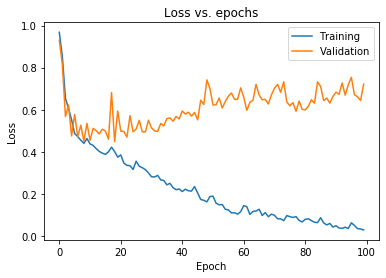

In [5]:


import matplotlib.pyplot as plt

fig1 = plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
fig1.show()

### Using Model regularization to improve the model's overfit problem

2/2 - 0s - loss: 0.6349 - mae: 0.6328


C:\Users\zhaoh\anaconda3\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


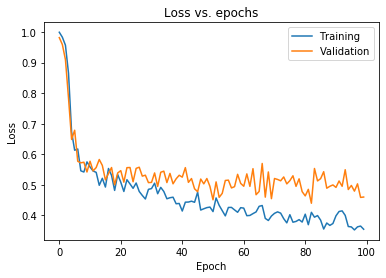

In [6]:

# Adding regularisation with weight decay and dropout in the model


from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer=regularizers.l2(wd),activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd),activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd),activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd),activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd),activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd),activation="relu"),
        Dense(1)
    ])
    return model


# Re-build the model with weight decay and dropout layers
model = get_regularised_model(1e-5,0.3)

# Compile the model
model.compile(optimizer='adam',loss='mse',metrics=['mae'])

# Train the model, with some of the data reserved for validation
history=model.fit(train_data,train_targets,epochs=100,validation_split=0.15,batch_size=64,verbose=False)

# Evaluate the model on the test set
model.evaluate(test_data,test_targets,verbose=2)

# Plot the training and validation loss
fig2 = plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
fig2.show()



### Introduction to callbacks

In [7]:

# Write a custom callback
from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
    
    def on_train_begin(self,logs=None):
        print("starting training ......")
    
    def on_epoch_begin(self,epoch,logs=None):
        print(f"starting epoch: {epoch} -->")
        
    def on_train_batch_begin(self,batch,logs=None):
        print(f"Training: starting batch {batch}")
        
    def on_train_batch_end(self,batch,logs=None):
        print(f"Training: finished batch {batch}")        
        
    def on_epoch_end(self,epoch,logs=None):
        print(f"finished epoch: {epoch} <--")
        
    def on_train_end(self,logs=None):
        print("Finished training ......")
        
class TestingCallback(Callback):
    
    def on_test_begin(self,logs=None):
        print("starting testing ......")
        
    def on_test_batch_begin(self,batch,logs=None):
        print(f"Testing: starting batch {batch}")
        
    def on_test_batch_end(self,batch,logs=None):
        print(f"Testing: finished batch {batch}")        
        
    def on_test_end(self,logs=None):
        print("Finished testing ......")        

class PredictionCallback(Callback):
    
    def on_predict_begin(self,logs=None):
        print("starting predicting ......")
        
    def on_predict_batch_begin(self,batch,logs=None):
        print(f"Predicting: starting batch {batch}")
        
    def on_predict_batch_end(self,batch,logs=None):
        print(f"Predicting: finished batch {batch}")        
        
    def on_predict_end(self,logs=None):
        print("Finished predicting ......")     
        
        
# Re-build the model
model = get_regularised_model(1e-5,0.3)

# Compile the model
model.compile(optimizer='adam',loss='mse')

# Train the model, with some of the data reserved for validation
history=model.fit(train_data,train_targets,epochs=3,batch_size=128,verbose=False,callbacks=[TrainingCallback()])

# Evaluate the model
model.evaluate(test_data,test_targets,verbose=False,callbacks=[TestingCallback()])

# Make predictions with the model
model.predict(test_data,verbose=False,callbacks=[PredictionCallback()])


starting training ......
starting epoch: 0 -->
Training: starting batch 0
Training: finished batch 0
Training: starting batch 1
Training: finished batch 1
Training: starting batch 2
Training: finished batch 2
Training: starting batch 3
Training: finished batch 3
finished epoch: 0 <--
starting epoch: 1 -->
Training: starting batch 0
Training: finished batch 0
Training: starting batch 1
Training: finished batch 1
Training: starting batch 2
Training: finished batch 2
Training: starting batch 3
Training: finished batch 3
finished epoch: 1 <--
starting epoch: 2 -->
Training: starting batch 0
Training: finished batch 0
Training: starting batch 1
Training: finished batch 1
Training: starting batch 2
Training: finished batch 2
Training: starting batch 3
Training: finished batch 3
finished epoch: 2 <--
Finished training ......
starting testing ......
Testing: starting batch 0
Testing: finished batch 0
Testing: starting batch 1
Testing: finished batch 1
Finished testing ......
starting predictin

array([[ 0.00236298],
       [ 0.00981055],
       [-0.17767626],
       [-0.11997886],
       [-0.1655179 ],
       [-0.11367434],
       [-0.13184328],
       [-0.10723002],
       [-0.03079619],
       [-0.17160818],
       [-0.09102561],
       [-0.19292967],
       [-0.04595215],
       [-0.00068817],
       [-0.20553602],
       [-0.21066085],
       [-0.24367802],
       [-0.15127608],
       [-0.02026674],
       [-0.00181945],
       [-0.16693346],
       [-0.03367356],
       [-0.14717896],
       [-0.24383138],
       [-0.15643516],
       [-0.13695073],
       [-0.19265029],
       [-0.13766503],
       [ 0.00494476],
       [-0.01860392],
       [ 0.00398846],
       [-0.22204816],
       [ 0.01247501],
       [ 0.01006011],
       [-0.21646367],
       [-0.21398365],
       [-0.05589603],
       [-0.19062455],
       [-0.23321971],
       [-0.18660513],
       [ 0.00244402],
       [-0.16146813],
       [-0.21785006],
       [ 0.00305658],
       [-0.01161148]], dtype=flo